# UJIAN AKHIR SEMESTER
## TIMESERIES

### NAMA : Paul Wijaya Verda Kusuma
### NIM  : 215314051

### LSTM untuk Klasifikasi Trend Saham Evolutionary Algorithm`
### BTC-USD

In [1]:
!pip install numpy pandas scikit-learn tensorflow joblib deap

In [2]:
# === [1] STABILITAS & REPRODUCIBILITY ===
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
# === Library Setup ===
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import warnings
warnings.filterwarnings("ignore")

In [4]:
# === [3] LOAD DATA ===
df = pd.read_csv('/content/sample_data/BTC-USD_processed_data.csv', index_col='Date', parse_dates=True)

# === Fitur Teknikal Tambahan ===
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['ROC5'] = df['Close'].pct_change(periods=5)

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close'])
df['EMA10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['BB_MA'] = df['Close'].rolling(window=20).mean()
df['BB_STD'] = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_MA'] + 2 * df['BB_STD']
df['BB_Lower'] = df['BB_MA'] - 2 * df['BB_STD']
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()

df.dropna(inplace=True)

# === [5] SCALING ===
features = [
    'Close', 'High', 'Low', 'Open', 'MA5', 'MA10', 'ROC5', 'RSI',
    'EMA10', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal', 'ATR'
]
data = df[features]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
joblib.dump(scaler, 'scaler_btc_usd.pkl')

['scaler_btc_usd.pkl']

In [5]:
def generate_dataset(data_scaled, window_size):

    X, y = [], []
    close_prices = scaler.inverse_transform(data_scaled)[:, 0]
    log_returns = np.log(close_prices[1:] / close_prices[:-1])

    # Hitung threshold log return kuantil & batasi minimum perubahan signifikan
    up_thresh = np.quantile(log_returns, 0.70)
    down_thresh = np.quantile(log_returns, 0.30)

    for i in range(len(data_scaled) - window_size - 1):
        X.append(data_scaled[i:i + window_size])
        prev_close = close_prices[i + window_size - 1]
        next_close = close_prices[i + window_size]
        log_ret = np.log(next_close / prev_close)

        if log_ret > up_thresh:
            label = [0, 0, 1]  # Naik
        elif log_ret < down_thresh:
            label = [1, 0, 0]  # Turun
        else:
            label = [0, 1, 0]  # Stasioner
        y.append(label)

    # Untuk debugging: lihat distribusi kelas
    label_counts = np.sum(y, axis=0)
    print(f"Distribusi Label (Turun, Stasioner, Naik): {label_counts}")

    return np.array(X), np.array(y), up_thresh, down_thresh

def split_dataset(X, y, ratio=0.8):
    split = int(len(X) * ratio)
    return X[:split], X[split:], y[:split], y[split:]

def get_class_weight(y):
    y_int = np.argmax(y, axis=1)
    classes = np.unique(y_int)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_int)
    return dict(zip(classes, weights))

In [6]:
# === [7] MODEL LSTM ===
def create_model(units, optimizer_name, lr, input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(units // 2),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.get(optimizer_name)
    optimizer.learning_rate = lr
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
# === [8] GA: VARIABEL GLOBAL & EVALUATOR ===
global_X_train, global_X_test = None, None
global_y_train, global_y_test = None, None
global_input_shape = None

def eval_fitness(ind):
    global global_X_train, global_X_test, global_y_train, global_y_test, global_input_shape

    units = max(16, int(ind[0]))
    opt_idx = int(round(ind[1])) % 4
    lr_exp = max(2.5, min(5.0, ind[2]))
    epochs = max(5, int(ind[3]))

    optimizer = ['adam', 'rmsprop', 'nadam', 'adamax'][opt_idx]
    lr = 10 ** (-lr_exp)

    # Pakai input_shape global
    model = create_model(units, optimizer, lr, global_input_shape)
    class_weight = get_class_weight(global_y_train)
    early = EarlyStopping(patience=5, restore_best_weights=True)

    model.fit(global_X_train, global_y_train, epochs=epochs, batch_size=32, verbose=0,
              validation_data=(global_X_test, global_y_test), callbacks=[early],
              class_weight=class_weight)

    _, acc = model.evaluate(global_X_test, global_y_test, verbose=0)
    ind.model = model
    return (acc,)

In [8]:
# === [9] INISIALISASI DEAP ===
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("units", random.randint, 32, 128)
toolbox.register("opt_idx", random.randint, 0, 3)
toolbox.register("lr_exp", random.uniform, 2.5, 4.5)
toolbox.register("epochs", random.randint, 5, 30)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.units, toolbox.opt_idx, toolbox.lr_exp, toolbox.epochs), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval_fitness)


=== Evaluating Window Size: 10 ===
Distribusi Label (Turun, Stasioner, Naik): [1148 1529 1142]
gen	nevals
0  	7     
1  	4     
2  	3     
3  	3     
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

       Turun       0.34      0.12      0.18       218
   Stasioner       0.45      0.91      0.60       339
        Naik       0.00      0.00      0.00       207

    accuracy                           0.44       764
   macro avg       0.26      0.34      0.26       764
weighted avg       0.30      0.44      0.32       764



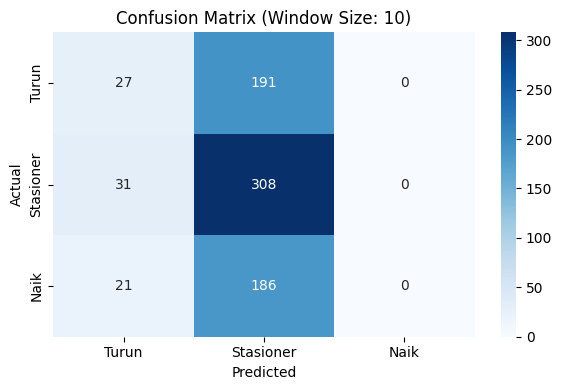


=== Evaluating Window Size: 20 ===
Distribusi Label (Turun, Stasioner, Naik): [1144 1524 1141]
gen	nevals
0  	7     
1  	4     
2  	6     
3  	5     
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

       Turun       0.00      0.00      0.00       218
   Stasioner       0.45      0.99      0.62       338
        Naik       0.40      0.02      0.04       206

    accuracy                           0.45       762
   macro avg       0.28      0.34      0.22       762
weighted avg       0.31      0.45      0.28       762



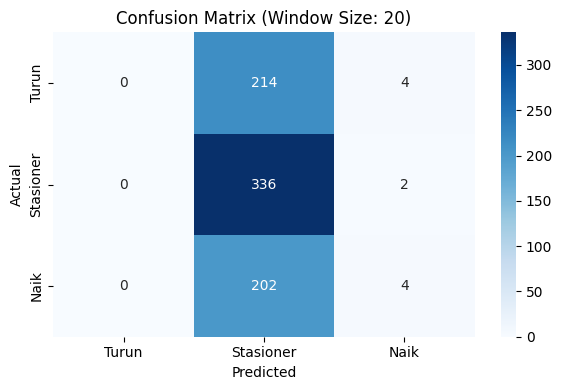


=== Evaluating Window Size: 30 ===
Distribusi Label (Turun, Stasioner, Naik): [1140 1520 1139]
gen	nevals
0  	7     
1  	2     
2  	5     
3  	5     
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

       Turun       0.00      0.00      0.00       217
   Stasioner       0.44      1.00      0.61       337
        Naik       0.00      0.00      0.00       206

    accuracy                           0.44       760
   macro avg       0.15      0.33      0.20       760
weighted avg       0.20      0.44      0.27       760



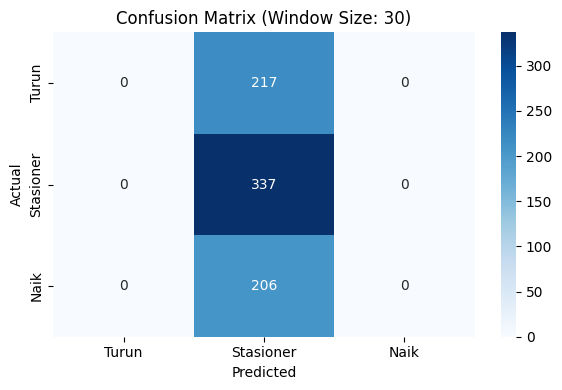


=== Evaluating Window Size: 40 ===
Distribusi Label (Turun, Stasioner, Naik): [1138 1516 1135]
gen	nevals
0  	7     
1  	4     
2  	5     
3  	4     
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
              precision    recall  f1-score   support

       Turun       0.38      0.08      0.13       217
   Stasioner       0.45      0.90      0.60       336
        Naik       0.24      0.04      0.07       205

    accuracy                           0.43       758
   macro avg       0.36      0.34      0.27       758
weighted avg       0.37      0.43      0.32       758



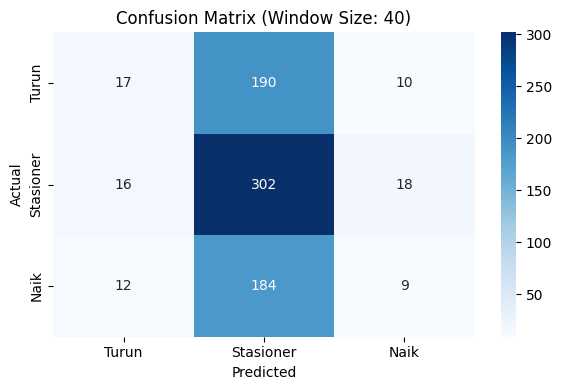

In [9]:
 #=== [10] LOOP WINDOW SIZE ===
results = []
window_sizes = [10, 20, 30, 40]

for window_size in window_sizes:
    print(f"\n=== Evaluating Window Size: {window_size} ===")
    X, y, up_thresh, down_thresh = generate_dataset(data_scaled, window_size)
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    global_X_train, global_X_test = X_train, X_test
    global_y_train, global_y_test = y_train, y_test
    global_input_shape = (X_train.shape[1], X_train.shape[2])

    pop = toolbox.population(n=7)
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=3, stats=None, halloffame=hof, verbose=True)

    best_ind = hof[0]
    best_model = best_ind.model
    acc = best_ind.fitness.values[0]

    results.append((window_size, acc, best_ind, best_model, up_thresh, down_thresh))

    y_pred = best_model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(classification_report(y_true, y_pred_class, target_names=['Turun', 'Stasioner', 'Naik']))
    cm = confusion_matrix(y_true, y_pred_class)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Turun', 'Stasioner', 'Naik'],
                yticklabels=['Turun', 'Stasioner', 'Naik'])
    plt.title(f"Confusion Matrix (Window Size: {window_size})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [10]:
# === [11] SIMPAN MODEL TERBAIK ===
best_result = max(results, key=lambda x: x[1])
best_window, best_acc, best_ind, best_model, best_up, best_down = best_result
filename = f"best_model_BTC_ws{best_window}.h5"
best_model.save(filename)
print(f"\nBest Window Size: {best_window}, Accuracy: {best_acc:.4f}")
print(f"Best Threshold Naik: {best_up:.6f}")
print(f"Best Threshold Turun: {best_down:.6f}")
print(f"Model saved as: {filename}")

# === Cetak Arsitektur Terbaik ===
units, opt_idx, lr_exp, epochs = best_ind
optimizers = ['adam', 'rmsprop', 'nadam', 'adamax']
optimizer = optimizers[int(round(opt_idx)) % len(optimizers)]
lr = 10 ** (-lr_exp)

print("\n=== Arsitektur Terbaik ===")
print(f"Units LSTM         : {int(units)}")
print(f"Optimizer          : {optimizer}")
print(f"Learning Rate      : {lr:.6f}")
print(f"Epochs             : {int(epochs)}")


Best Window Size: 20, Accuracy: 0.4462
Best Threshold Naik: 0.012605
Best Threshold Turun: -0.008555
Model saved as: best_model_BTC_ws20.h5

=== Arsitektur Terbaik ===
Units LSTM         : 72
Optimizer          : nadam
Learning Rate      : 0.000329
Epochs             : 26


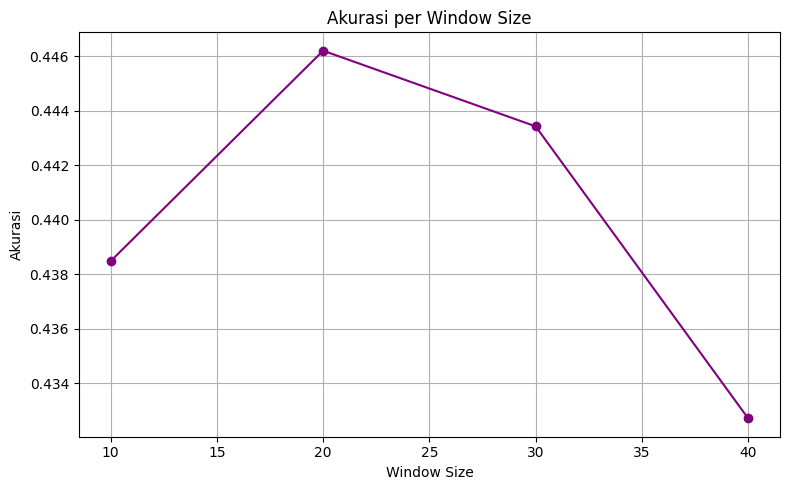

In [11]:
# === [12] VISUALISASI AKURASI PER WINDOW ===
plt.figure(figsize=(8, 5))
plt.plot([r[0] for r in results], [r[1] for r in results], marker='o', linestyle='-', color='purple')
plt.title("Akurasi per Window Size")
plt.xlabel("Window Size")
plt.ylabel("Akurasi")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# === STEP 8: Prediksi Pergerakan Berikutnya ===
print("\n=== Prediksi Pergerakan Berikutnya ===")

# Ambil window terakhir dari data untuk prediksi
latest_sequence = data_scaled[-best_window:]  # best_window berasal dari hasil terbaik
latest_sequence = np.expand_dims(latest_sequence, axis=0)  # Sesuaikan dimensi untuk LSTM

# Prediksi
prediction = best_model.predict(latest_sequence)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

# Mapping kelas
class_mapping = {0: 'Turun', 1: 'Stasioner', 2: 'Naik'}
predicted_label = class_mapping[predicted_class]

print(f"Prediksi Pergerakan Berikutnya: {predicted_label} (Probabilitas: {confidence:.2f})")


=== Prediksi Pergerakan Berikutnya ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediksi Pergerakan Berikutnya: Stasioner (Probabilitas: 0.36)


In [13]:
# === PREDIKSI DATASET BARU ===

from tensorflow.keras.models import load_model

# === Load model & scaler yang sudah disimpan ===
model = load_model(filename)
scaler = joblib.load('scaler_btc_usd.pkl')

# === Load dan proses dataset baru ===
new_df = pd.read_csv('/content/sample_data/ETH-USD_processed_data.csv', index_col='Date', parse_dates=True)

# === Tambahkan fitur teknikal yang sama ===
new_df['MA5'] = new_df['Close'].rolling(window=5).mean()
new_df['MA10'] = new_df['Close'].rolling(window=10).mean()
new_df['ROC5'] = new_df['Close'].pct_change(periods=5)
new_df['RSI'] = calculate_rsi(new_df['Close'])
new_df['EMA10'] = new_df['Close'].ewm(span=10, adjust=False).mean()
new_df['BB_MA'] = new_df['Close'].rolling(window=20).mean()
new_df['BB_STD'] = new_df['Close'].rolling(window=20).std()
new_df['BB_Upper'] = new_df['BB_MA'] + 2 * new_df['BB_STD']
new_df['BB_Lower'] = new_df['BB_MA'] - 2 * new_df['BB_STD']
ema12_new = new_df['Close'].ewm(span=12, adjust=False).mean()
ema26_new = new_df['Close'].ewm(span=26, adjust=False).mean()
new_df['MACD'] = ema12_new - ema26_new
new_df['MACD_Signal'] = new_df['MACD'].ewm(span=9, adjust=False).mean()
new_df['H-L'] = new_df['High'] - new_df['Low']
new_df['H-PC'] = abs(new_df['High'] - new_df['Close'].shift(1))
new_df['L-PC'] = abs(new_df['Low'] - new_df['Close'].shift(1))
new_df['TR'] = new_df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
new_df['ATR'] = new_df['TR'].rolling(window=14).mean()

new_df.dropna(inplace=True)

# === Ambil fitur & scaling ===
new_data = new_df[features]
new_data_scaled = scaler.transform(new_data)

# === Ambil window terakhir dari dataset baru untuk prediksi ===
if len(new_data_scaled) >= best_window:
    latest_input = new_data_scaled[-best_window:]
    latest_input = np.expand_dims(latest_input, axis=0)  # shape: (1, window, features)

    # === Prediksi ===
    pred_prob = model.predict(latest_input)
    pred_class = np.argmax(pred_prob, axis=1)[0]
    class_labels = ['Turun', 'Stasioner', 'Naik']
    confidence = pred_prob[0][pred_class]

    # === Tampilkan hasil ===
    print("\n=== Prediksi Dataset Baru (1 langkah ke depan) ===")
    print(f"Arah Prediksi       : {class_labels[pred_class]}")
    print(f"Probabilitas        : Turun={pred_prob[0][0]:.4f}, Stasioner={pred_prob[0][1]:.4f}, Naik={pred_prob[0][2]:.4f}")
    print(f"Confidence          : {confidence:.4f}")
else:
    print("Dataset baru tidak cukup panjang untuk window size ini.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step

=== Prediksi Dataset Baru (1 langkah ke depan) ===
Arah Prediksi       : Naik
Probabilitas        : Turun=0.2987, Stasioner=0.3493, Naik=0.3521
Confidence          : 0.3521
